## Preface
In this notebook I am going to build and compare several ML Regression models for predicting a song popularity. I am going to compare and contrast b/w Linear Models like linear, lasso, ridge and elastic net regression and Tree-Based models like Decision Tree, Random Forest, AdaBoost, GBoost and  XGboost.<br> <br>I will do this by following the below stages of a **Data Science project lifecycle** <br>
* **Exploratory Data Analysis** (Refer this notebook)
* **Feature Engineering**
    * Feature Selection
    * Feature Scaling of numerical features
    * One Hot Encoding of categorical features
* **Modelling**
    * Linear Models
        * *Linear Regression*
        * *Lasso Regression*
        * *Ridge Regression*
        * *ElasticNet Regression*
    * Tree Based Ensemble Models
        * Bagging Techniques
            * *Random Forest*
        * Boosting Techniques
            * *AdaBoost*
            * *Gradient Boosting*
            * *XGBoost*
    * Artificial Neural Network (Refer this notebook)
* **Hyperparameter Tuning**
* **Model Evaluation**
    * Metrices used
        * *R2 Score*
        * *Root Mean Squared Error*
        * *Mean Squared Error*
        * *Mean Absolute Error*
* **Model Deployment**

## Importing essential libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.target import FeatureCorrelation # Feature Selection

from sklearn.preprocessing import MinMaxScaler # Feature Scaling
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold # Hyperparameter Tuning

# Modelling
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet # Linear Models
from sklearn.ensemble import RandomForestRegressor # Ensemble - Bagging Techniques
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor # Ensemble - Boosting Techniques
from xgboost import XGBRegressor # Extreme Gradient Boosting

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Regression Metrices

import pickle
import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [51]:
data = pd.read_csv('SpotifyFeatures.csv')
print("Shape of Data - ", data.shape)
data.head(2)

Shape of Data -  (232725, 18)


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.0,F#,0.151,-5.559,Minor,0.0868,174.003,4/4,0.816


## Feature Selection <br>
Feature Selection will be done based on <br>
* How much a predictor feature is correlated with the target features.
* Whether any two features are highly positively correlated with each other. (Muticollinearity)
* Features the that are of least importance for the XGBoost

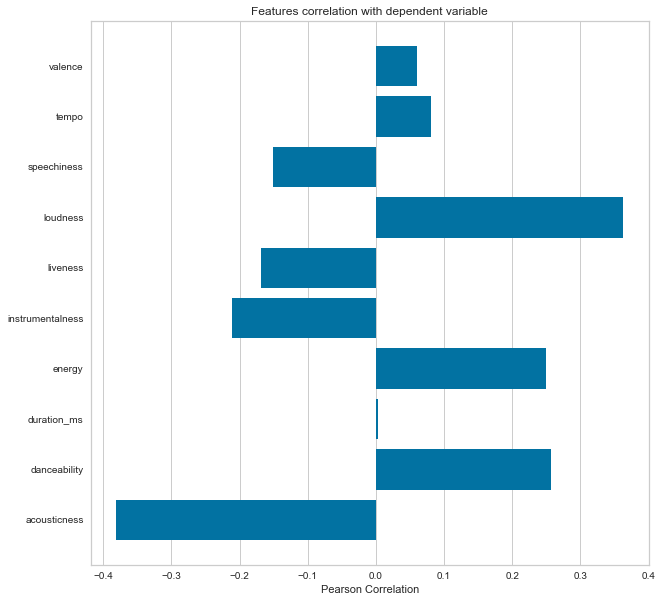

In [52]:
# Plotting Feature Correlation with Target Feature

# Select all the numerical features except for the target feature
features = [col for col in data.columns if col != 'popularity' and data[col].dtype != 'O']

X = data[features] # independent features
y = data['popularity'] # target feature

fc = FeatureCorrelation(labels=features)
plt.rcParams['figure.figsize'] = (10, 10)

fc.fit(X, y)
fc.show()

Looks like **Duration of Song** has **no correlation** with its **Popularity**.<br>
Therefore we can eliminate **duration_ms**.<br>
But we can spare **valence** and **tempo** for now, I guess.

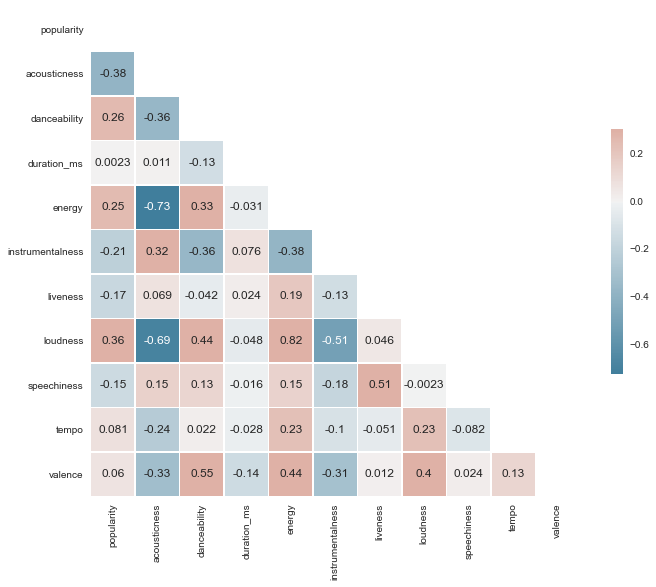

In [53]:
# Compute the correlation matrix
corr = data.corr()

# Generate the mask for upper triangular matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

I don't see any **Multicollinearity** here, except for **Loudness** and **Energy**, but I am sparing all them features for now.

## Dropping Unnecessary Features

In [54]:
data.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [55]:
data.drop(
    ['artist_name', 'track_name', 'track_id', 'duration_ms', 'key', 'mode', 'time_signature', 'tempo', 'valence'], 
    axis=1, inplace=True
)
# key, mode, time_signature, tempo and valence as they ranked very low w.r.t. XGBRegressor's model feature importance.
data.columns

Index(['genre', 'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness'],
      dtype='object')

## Handling Numerical Features

In [56]:
num_features_scaled_bw_0_and_1 = [
            'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'
]
other_num_features = ['loudness']

In [57]:
# Scaling other numerical features between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
data[other_num_features] = scaler.fit_transform(data[other_num_features])

## Handling Categorical Features

In [58]:
data.groupby('genre')['popularity'].count()

genre
A Capella            119
Alternative         9263
Anime               8936
Blues               9023
Children's Music    5403
Children’s Music    9353
Classical           9256
Comedy              9681
Country             8664
Dance               8701
Electronic          9377
Folk                9299
Hip-Hop             9295
Indie               9543
Jazz                9441
Movie               7806
Opera               8280
Pop                 9386
R&B                 8992
Rap                 9232
Reggae              8771
Reggaeton           8927
Rock                9272
Ska                 8874
Soul                9089
Soundtrack          9646
World               9096
Name: popularity, dtype: int64

In [59]:
cat_features = ['genre'] # Genre played an important role for predicting popularity

data = pd.get_dummies(data, columns=cat_features) # One Hot Encoding of Categorical features
data.drop('genre_A Capella', axis=1, inplace=True) # A Capella was there only 119 times
data.head(2)

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,genre_Alternative,genre_Anime,...,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World
0,0,0.611,0.389,0.910,0.0,0.346,0.900856,0.0525,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.246,0.590,0.737,0.0,0.151,0.834469,0.0868,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modelling

In [60]:
X = data.drop(['popularity'], axis=1) # independent features
y = data['popularity'] # dependent features

### Dimensionality Reduction for visualization

In [61]:
pca = PCA(n_components=1) # Taking 1 components just so we can visualize better
X = pca.fit_transform(X)

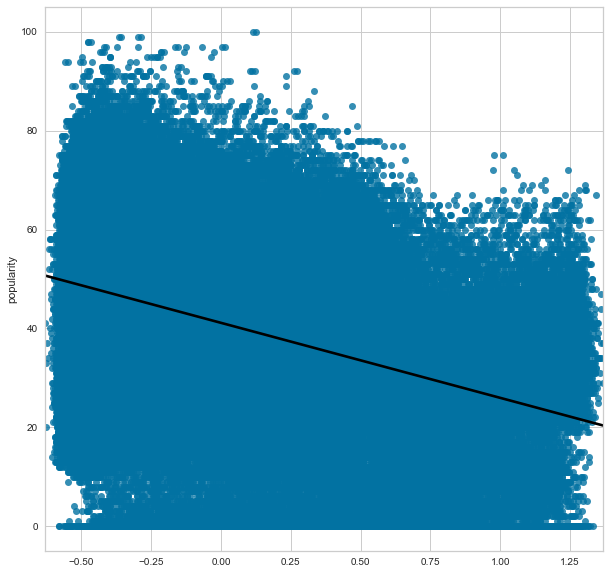

In [37]:
sns.regplot(X, y, line_kws={'color': 'black'})

**Clearly Predicting Popularity will give me hell!**. But I will try my best to up my r2-score

In [62]:
X = data.drop(['popularity'], axis=1) # independent features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Math behind the metrices used

#### R2 Score
  <img src='https://miro.medium.com/max/2812/1*_HbrAW-tMRBli6ASD5Bttw.png' width="300">

**Best possible r2-score is 1.0** and it can be negative (because the model can be arbitrarily worse). 
<br>A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
 
#### Mean Squared Error
  <img src='https://cdn-media-1.freecodecamp.org/images/hmZydSW9YegiMVPWq2JBpOpai3CejzQpGkNG' width='300'>
  
#### Mean Absolute Error
  <img src='https://miro.medium.com/max/1040/1*tu6FSDz_FhQbR3UHQIaZNg.png' width='300'>
 
#### Root Mean Squared Error
  <img src='https://miro.medium.com/max/966/1*lqDsPkfXPGen32Uem1PTNg.png' width='300'>
 
**Model with the least rmse, mse and mae would the best model.**

In [63]:
# Regression Model Report

def build_model_report(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error
    mse = mean_squared_error(y_test, y_pred) # Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred) # R2 Score
    
    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2_score': r2}

### Cross Validation

In [85]:
# K-fold Cross Validaiton

def cross_validate(model, X, y, n_splits=5):
    
    kfold = KFold(n_splits, True)
    scores = []

    # enumerate splits
    for train, test in kfold.split(data):
        train_X, test_X = X.iloc[train], X.iloc[test]
        train_Y, test_Y = y.iloc[train], y.iloc[test]

        model = model.fit(train_X, train_Y)
        pred_Y = model.predict(test_X)
        score = build_model_report(model, X_test, y_test)
        scores.append(score)
    
    # Mean Scores
    mae = np.mean([score['mae'] for score in scores])
    mse = np.mean([score['mse'] for score in scores])
    rmse = np.mean([score['rmse'] for score in scores])
    r2 = np.mean([score['r2_score'] for score in scores])
    
    print("Mean Absolute Error - ", mae)
    print("Mean Squared Error - ", mse)
    print("Root Mean Squared Error - ", rmse)
    print("R2-Score", r2)
    
    return scores

## Linear Models

### Linear Regression

In [65]:
# Linear Regression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

print(build_model_report(model_lr, X_test, y_test))

{'mae': 7.264327231600565, 'mse': 91.54074538307512, 'rmse': 9.56769279309673, 'r2_score': 0.7240713263593559}


In [96]:
# Linear Regression with 10-Fold CV

model_lr_cv = LinearRegression()

score_lr = cross_validate(model_lr_cv, X, y, 10)

Mean Absolute Error -  7.260376162109507
Mean Squared Error -  91.5072677680592
Root Mean Squared Error -  9.565943117920101
R2-Score 0.7241722369852127


### L1 Regulartization - Lasso Regression

In [91]:
# Lasso Regression - L1 Regularization

model_l1 = Lasso()
model_l1.fit(X_train, y_train)

score_l1 = build_model_report(model_l1, X_test, y_test)
print(score_l1)

{'mae': 13.90421032725752, 'mse': 292.1467757799946, 'rmse': 17.092301652498254, 'r2_score': 0.11939025608733178}


In [68]:
# Lasso Regression with 10-Fold CV

model_l1_cv = Lasso()

scores = cross_validate(model_l1_cv, X, y, n_splits=10)

Mean Absolute Error -  13.90715974655954
Mean Squared Error -  292.2452546428835
Root Mean Squared Error -  17.095181992596164
R2-Score 0.11909341404278802


In [69]:
param_grid = {
    'alpha': np.array([5, 0.5, 0.05, 1, 0.1, 0.01])
}
grid_lasso = GridSearchCV(
        estimator=Lasso(),
        param_grid=param_grid,
        cv=10, scoring='neg_root_mean_squared_error'
    )
grid_lasso.fit(X, y)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': array([5.  , 0.5 , 0.05, 1.  , 0.1 , 0.01])},
             scoring='neg_root_mean_squared_error')

In [87]:
print("Best Estimator ", grid_lasso.best_estimator_)
print("Best Score ", -grid_lasso.best_score_)

Best Estimator  Lasso(alpha=0.05)
Best Score  14.19637648891776


In [92]:
score_l1 = build_model_report(grid_lasso, X_test, y_test)
print(score_l1)

{'mae': 7.3829813433476525, 'mse': 94.10178332097261, 'rmse': 9.700607368663707, 'r2_score': 0.7163516623082253}


### L2 Regularization - Ridge Regression

In [71]:
# Ridge Regression - L2 Regularization

model_l2 = Ridge()
model_l2.fit(X_train, y_train)

print(build_model_report(model_l2, X_test, y_test))

{'mae': 7.266414236382419, 'mse': 91.57896885477122, 'rmse': 9.569690112786892, 'r2_score': 0.7239561104322525}


In [72]:
param_grid = {
    'alpha': np.array([5, 0.5, 0.05, 1, 0.1, 0.01])
}
grid_ridge = GridSearchCV(
        estimator=Ridge(),
        param_grid=param_grid,
        cv=10, scoring='neg_root_mean_squared_error'
    )
grid_ridge.fit(X, y)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([5.  , 0.5 , 0.05, 1.  , 0.1 , 0.01])},
             scoring='neg_root_mean_squared_error')

In [73]:
print("Best Estimator ", grid_ridge.best_estimator_)
print("Best Score ", grid_ridge.best_score_)

Best Estimator  Ridge(alpha=5.0)
Best Score  -13.95082338870784


In [93]:
score_l2 = build_model_report(grid_ridge, X_test, y_test)
print(score_l2)

{'mae': 7.266862072678095, 'mse': 91.67650097900179, 'rmse': 9.574784644001232, 'r2_score': 0.7236621221152066}


### Combining Both Lasso and Ridge Regression - ElasticNet Regression

In [74]:
# ElasticNet Regression

model_en = ElasticNet()
model_en.fit(X_train, y_train)

print(build_model_report(model_en, X_test, y_test))

{'mae': 14.262861963714304, 'mse': 305.5419324324001, 'rmse': 17.479757791010723, 'r2_score': 0.07901361514083738}


In [75]:
param_grid = {
    'alpha': np.array([5, 0.5, 0.05, 1, 0.1, 0.01])
}
grid_en = GridSearchCV(
        estimator=ElasticNet(),
        param_grid=param_grid,
        cv=10, scoring='neg_root_mean_squared_error'
    )
grid_en.fit(X, y)

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': array([5.  , 0.5 , 0.05, 1.  , 0.1 , 0.01])},
             scoring='neg_root_mean_squared_error')

In [76]:
print("Best Estimator ", grid_en.best_estimator_)
print("Best Score ", grid_en.best_score_)

Best Estimator  ElasticNet(alpha=0.01)
Best Score  -13.847953532144725


In [94]:
score_en = build_model_report(grid_en, X_test, y_test)
print(score_en)

{'mae': 7.534837117096666, 'mse': 96.92468658692788, 'rmse': 9.845033600091362, 'r2_score': 0.7078426650225762}


## Ensemble Models

### Bagging - Random Forest

In [77]:
model_rfc = RandomForestRegressor()
model_rfc.fit(X_train, y_train)

print(build_model_report(model_rfc, X_test, y_test))

{'mae': 7.245094406675909, 'mse': 90.65856086378912, 'rmse': 9.52147892208921, 'r2_score': 0.7267304701460298}


### Boosting - AdaBoost

In [78]:
model_ada = AdaBoostRegressor()
model_ada.fit(X_train, y_train)

print(build_model_report(model_ada, X_test, y_test))

{'mae': 12.329806523537416, 'mse': 228.6865696902046, 'rmse': 15.122386375509805, 'r2_score': 0.3106765562156588}


### Boosting - Gradient Boosting

In [79]:
model_gb = GradientBoostingRegressor(verbose=2)
model_gb.fit(X_train, y_train)

print(build_model_report(model_gb, X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1         310.5381            1.58m
         2         293.5500            1.50m
         3         279.3901            1.44m
         4         266.8460            1.40m
         5         256.2881            1.38m
         6         246.4694            1.35m
         7         237.3162            1.33m
         8         229.3524            1.32m
         9         222.3402            1.30m
        10         215.8905            1.28m
        11         209.5221            1.26m
        12         203.8834            1.25m
        13         198.1062            1.23m
        14         193.1746            1.21m
        15         188.7654            1.20m
        16         184.7004            1.18m
        17         180.6215            1.17m
        18         176.8445            1.15m
        19         173.5257            1.14m
        20         170.2937            1.13m
        21         167.2719            1.11m
        2

### Boosting - Extreme Gradient Boosting (XGBoost)

In [80]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

print(build_model_report(model_xgb, X_test, y_test))

{'mae': 7.137892210991621, 'mse': 88.36104028312246, 'rmse': 9.400055334045778, 'r2_score': 0.7336558212979403}


In [81]:
model_xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 2,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

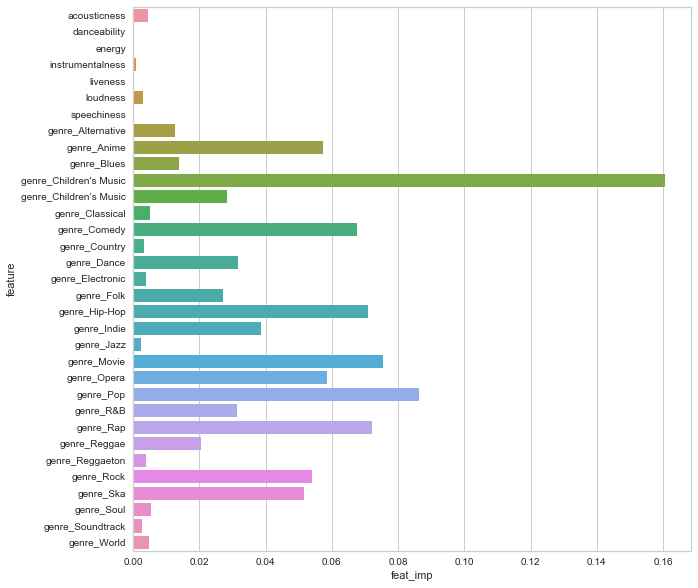

In [82]:
# Plotting features importance for XGBoost
feat_imp = model_xgb.feature_importances_
feat = data.drop(['popularity'],axis=1).columns.values
imp_feat_df = pd.DataFrame({'feature': feat, 'feat_imp': feat_imp})
sns.barplot(imp_feat_df['feat_imp'], imp_feat_df['feature'], orient='h')